In [1]:
%matplotlib widget
import os
import re
import pandas
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from lmfit import Model
import pickle

from matplotlib.widgets import SpanSelector,Button
from ipywidgets import interact, interact_manual, FloatSlider, Dropdown, SelectionRangeSlider

# Experiment 1: 0.5mM NADH

In [2]:
data_NADH1 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD1.xlsx")
#A view of the data
data_NADH1.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.730110,0.818919,0.808044,0.866192,0.881057,0.866816,0.894276,0.827030,0.880791,...,0.775194,0.761075,0.779466,0.790894,0.826977,0.744263,0.748449,0.772077,0.770911,0.776433
1,0.076367,0.730501,0.816616,0.805351,0.862524,0.874688,0.887102,0.869874,0.833596,0.881151,...,0.770892,0.765306,0.777212,0.778126,0.849969,0.754115,0.754146,0.770498,0.770542,0.819622
2,0.159783,0.730782,0.822675,0.807660,0.864085,0.867355,0.909525,0.881105,0.820295,0.876113,...,0.769377,0.762606,0.777689,0.764539,0.827823,0.752544,0.756396,0.774793,0.769119,0.784378
3,0.242833,0.733200,0.819777,0.805535,0.858612,0.871864,0.895074,0.869504,0.818648,0.880631,...,0.771141,0.761910,0.778795,0.759887,0.824699,0.745812,0.751959,0.773557,0.767689,0.806326
4,0.326167,0.728536,0.817481,0.801536,0.855452,0.869638,0.894284,0.858060,0.811674,0.877428,...,0.769013,0.761336,0.771145,0.751607,0.809367,0.756271,0.752910,0.772521,0.768566,0.792729


In [3]:
data_NADH1.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH1.columns]
data_NADH1.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.730110,0.818919,0.808044,0.866192,0.881057,0.866816,0.894276,0.827030,0.880791,...,0.775194,0.761075,0.779466,0.790894,0.826977,0.744263,0.748449,0.772077,0.770911,0.776433
1,0.076367,0.730501,0.816616,0.805351,0.862524,0.874688,0.887102,0.869874,0.833596,0.881151,...,0.770892,0.765306,0.777212,0.778126,0.849969,0.754115,0.754146,0.770498,0.770542,0.819622
2,0.159783,0.730782,0.822675,0.807660,0.864085,0.867355,0.909525,0.881105,0.820295,0.876113,...,0.769377,0.762606,0.777689,0.764539,0.827823,0.752544,0.756396,0.774793,0.769119,0.784378
3,0.242833,0.733200,0.819777,0.805535,0.858612,0.871864,0.895074,0.869504,0.818648,0.880631,...,0.771141,0.761910,0.778795,0.759887,0.824699,0.745812,0.751959,0.773557,0.767689,0.806326
4,0.326167,0.728536,0.817481,0.801536,0.855452,0.869638,0.894284,0.858060,0.811674,0.877428,...,0.769013,0.761336,0.771145,0.751607,0.809367,0.756271,0.752910,0.772521,0.768566,0.792729


In [4]:
samples = [s for s in data_NADH1.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH1.index,
    index=(0,40),
    description='Time_min')

In [5]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
   

C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\1590133685.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\1590133685.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


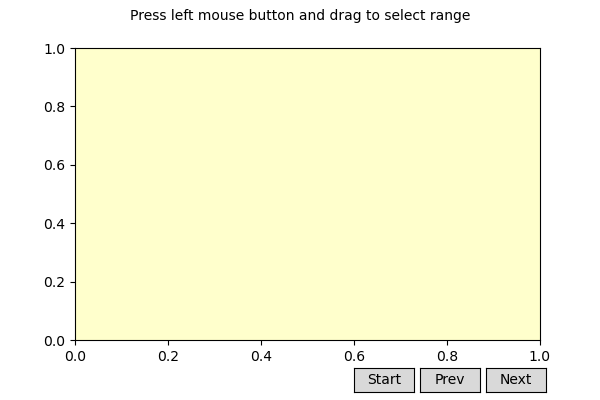

In [8]:
a=LinReg(data_NADH1)

In [9]:
slopes1 = a.make_summary()
slopes1.head()

,rate
Sample_A1,-0.038584
Sample_A2,-0.041049
Sample_A3,-0.045016
Sample_B1,-0.037486
Sample_B2,-0.036200


In [10]:
slopes1

,rate
Sample_A1,-0.038584
Sample_A2,-0.041049
Sample_A3,-0.045016
Sample_B1,-0.037486
Sample_B2,-0.036200
Sample_B3,-0.037015
Sample_C1,-0.035469
Sample_C2,-0.039104
Sample_C3,-0.038527
Sample_D1,-0.040653


In [15]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [16]:
slope1 = slope1 / El # umol/ml/min (mM/min)
slope1 = slope1 / (protein/V) # umol/min/mg prot
exp1rates = -slope1

In [22]:
writer = pandas.ExcelWriter('output_forward1.xlsx')
exp1rates.to_excel(writer, sheet_name='exp1')
writer.save()

# Experiment 2: 0.41mM NADH

In [16]:
data_NADH2 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD2.xlsx")
#A view of the data
data_NADH2.head()

,Time_min,A4,A5,A6,B4,B5,B6,C4,C5,C6,...,D6,E4,E5,E6,F4,F5,F6,G4,G5,G6
0,0.000000,0.747986,0.735997,0.801087,0.795456,0.784547,0.825493,0.757920,0.753281,0.785433,...,0.698629,0.671036,0.698392,0.723202,0.669343,0.675316,0.693430,0.659446,0.671951,0.701141
1,0.073783,0.762681,0.739213,0.800733,0.791569,0.786067,0.825477,0.762410,0.745085,0.785446,...,0.696103,0.674213,0.692004,0.737458,0.692034,0.664343,0.685784,0.665187,0.673310,0.744801
2,0.157350,0.757739,0.738131,0.800455,0.790019,0.776414,0.842201,0.769538,0.743171,0.782423,...,0.694568,0.675364,0.688246,0.731599,0.679647,0.664668,0.686931,0.662774,0.667529,0.746979
3,0.240467,0.754996,0.737584,0.796227,0.786878,0.777330,0.817968,0.762411,0.737379,0.772912,...,0.695983,0.670540,0.689011,0.702935,0.676545,0.667690,0.691128,0.663054,0.669848,0.712994
4,0.323983,0.755533,0.735172,0.792296,0.785812,0.773283,0.797609,0.768313,0.731474,0.768065,...,0.698312,0.669636,0.689815,0.689595,0.660185,0.664520,0.683757,0.665288,0.669644,0.715754


In [17]:

data_NADH2.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH2.columns]
data_NADH2.head()

,Time_min,Sample_A4,Sample_A5,Sample_A6,Sample_B4,Sample_B5,Sample_B6,Sample_C4,Sample_C5,Sample_C6,...,Sample_D6,Sample_E4,Sample_E5,Sample_E6,Sample_F4,Sample_F5,Sample_F6,Sample_G4,Sample_G5,Sample_G6
0,0.000000,0.747986,0.735997,0.801087,0.795456,0.784547,0.825493,0.757920,0.753281,0.785433,...,0.698629,0.671036,0.698392,0.723202,0.669343,0.675316,0.693430,0.659446,0.671951,0.701141
1,0.073783,0.762681,0.739213,0.800733,0.791569,0.786067,0.825477,0.762410,0.745085,0.785446,...,0.696103,0.674213,0.692004,0.737458,0.692034,0.664343,0.685784,0.665187,0.673310,0.744801
2,0.157350,0.757739,0.738131,0.800455,0.790019,0.776414,0.842201,0.769538,0.743171,0.782423,...,0.694568,0.675364,0.688246,0.731599,0.679647,0.664668,0.686931,0.662774,0.667529,0.746979
3,0.240467,0.754996,0.737584,0.796227,0.786878,0.777330,0.817968,0.762411,0.737379,0.772912,...,0.695983,0.670540,0.689011,0.702935,0.676545,0.667690,0.691128,0.663054,0.669848,0.712994
4,0.323983,0.755533,0.735172,0.792296,0.785812,0.773283,0.797609,0.768313,0.731474,0.768065,...,0.698312,0.669636,0.689815,0.689595,0.660185,0.664520,0.683757,0.665288,0.669644,0.715754


In [18]:
samples = [s for s in data_NADH2.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH2.index,
    index=(0,40),
    description='Time [min]',
)

In [19]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
           

C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\3657682931.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\3657682931.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


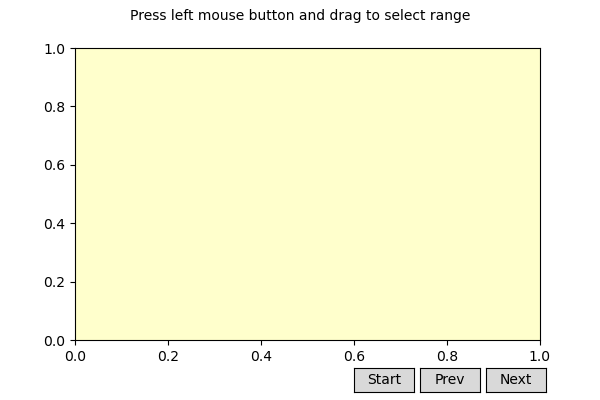

In [21]:
a=LinReg(data_NADH2)

In [22]:
slopes2 = a.make_summary()
slopes2.head()

,rate
Sample_A4,-0.040904
Sample_A5,-0.040121
Sample_A6,-0.045212
Sample_B4,-0.039120
Sample_B5,-0.038919


In [34]:
slopes2

,rate
Sample_A4,-0.038754
Sample_A5,-0.038051
Sample_A6,-0.038919
Sample_B4,-0.036445
Sample_B5,-0.034335
Sample_B6,-0.036491
Sample_C4,-0.034391
Sample_C5,-0.033731
Sample_C6,-0.033844
Sample_D4,-0.031899


In [41]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [42]:
slopes2 = slopes2 / El # umol/ml/min (mM/min)
slopes2 = slopes2 / (protein/V) # umol/min/mg prot
#slopes2_pre_complete = slopes2 / (-1) #sign change if needed 
exp2rates = -slopes2

In [47]:
writer = pandas.ExcelWriter('output_forward2.xlsx')
exp2rates.to_excel(writer, sheet_name='exp2')
writer.save()

# Experiment 3: 0.33mM NADH

In [23]:
data_NADH3 = pandas.read_excel(r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD3.xlsx")
#A view of the data
data_NADH3.head()

,Time_min,A7,A8,A9,B7,B8,B9,C7,C8,C9,...,D9,E7,E8,E9,F7,F8,F9,G7,G8,G9
0,0.000000,0.613158,0.676144,0.709055,0.726389,0.713313,0.731561,0.648607,0.680005,0.699078,...,0.621969,0.590865,0.613976,0.590093,0.575105,0.573683,0.602893,0.590939,0.595581,0.587627
1,0.075883,0.623237,0.688260,0.723912,0.727095,0.725282,0.762469,0.646619,0.686836,0.685901,...,0.624676,0.596835,0.608121,0.591486,0.572236,0.575221,0.608756,0.600102,0.604988,0.593645
2,0.159183,0.619762,0.692268,0.726248,0.726991,0.730597,0.740419,0.649336,0.691193,0.687692,...,0.627544,0.593450,0.611790,0.604202,0.587283,0.585969,0.610848,0.595964,0.589057,0.612864
3,0.242533,0.627265,0.689546,0.725269,0.725236,0.728735,0.741122,0.652210,0.690743,0.685233,...,0.626456,0.593989,0.613552,0.604414,0.585866,0.621193,0.611973,0.603786,0.594140,0.606261
4,0.325817,0.627418,0.683553,0.723226,0.724701,0.719043,0.737454,0.654645,0.685021,0.687085,...,0.621708,0.592636,0.605547,0.600962,0.591878,0.575838,0.613999,0.597832,0.593556,0.596294


In [24]:
data_NADH3.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH3.columns]
data_NADH3.head()

,Time_min,Sample_A7,Sample_A8,Sample_A9,Sample_B7,Sample_B8,Sample_B9,Sample_C7,Sample_C8,Sample_C9,...,Sample_D9,Sample_E7,Sample_E8,Sample_E9,Sample_F7,Sample_F8,Sample_F9,Sample_G7,Sample_G8,Sample_G9
0,0.000000,0.613158,0.676144,0.709055,0.726389,0.713313,0.731561,0.648607,0.680005,0.699078,...,0.621969,0.590865,0.613976,0.590093,0.575105,0.573683,0.602893,0.590939,0.595581,0.587627
1,0.075883,0.623237,0.688260,0.723912,0.727095,0.725282,0.762469,0.646619,0.686836,0.685901,...,0.624676,0.596835,0.608121,0.591486,0.572236,0.575221,0.608756,0.600102,0.604988,0.593645
2,0.159183,0.619762,0.692268,0.726248,0.726991,0.730597,0.740419,0.649336,0.691193,0.687692,...,0.627544,0.593450,0.611790,0.604202,0.587283,0.585969,0.610848,0.595964,0.589057,0.612864
3,0.242533,0.627265,0.689546,0.725269,0.725236,0.728735,0.741122,0.652210,0.690743,0.685233,...,0.626456,0.593989,0.613552,0.604414,0.585866,0.621193,0.611973,0.603786,0.594140,0.606261
4,0.325817,0.627418,0.683553,0.723226,0.724701,0.719043,0.737454,0.654645,0.685021,0.687085,...,0.621708,0.592636,0.605547,0.600962,0.591878,0.575838,0.613999,0.597832,0.593556,0.596294


In [25]:
samples = [s for s in data_NADH3.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH3.index,
    index=(0,40),
    description='Time [min]',
)

In [26]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


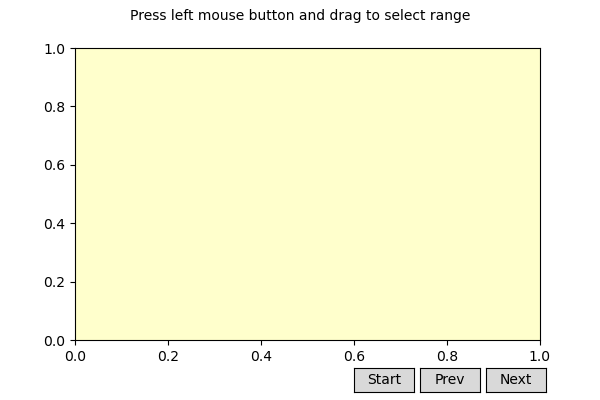

In [27]:
a=LinReg(data_NADH3)

In [28]:
slopes3 = a.make_summary()
slopes3.head()

,rate
Sample_A7,-0.036061
Sample_A8,-0.040687
Sample_A9,-0.048719
Sample_B7,-0.039882
Sample_B8,-0.045430


In [54]:
slopes3

,rate
Sample_A7,-0.036134
Sample_A8,-0.036993
Sample_A9,-0.036260
Sample_B7,-0.033185
Sample_B8,-0.032292
Sample_B9,-0.044082
Sample_C7,-0.033406
Sample_C8,-0.032511
Sample_C9,-0.033527
Sample_D7,-0.029777


In [61]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [62]:
slopes3 = slopes3 / El # umol/ml/min (mM/min)
slopes3 = slopes3 / (protein/V) # umol/min/mg prot
#slopes3_pre_complete = slopes3 / (-1) #sign change if needed 
exp3rates = -slopes3

In [68]:
writer = pandas.ExcelWriter('output_forward3.xlsx')
exp3rates.to_excel(writer, sheet_name='exp3')
writer.save()

# Experiment 4: 0.083mM NADH (at Km)

In [29]:
data_NADH4 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD4.xlsx")
#A view of the data
data_NADH4.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.463416,0.468009,0.452406,0.471950,0.465849,0.436939,0.382425,0.390532,0.395070,...,0.373816,0.347653,0.335610,0.338072,0.323407,0.323967,0.333365,0.321317,0.326078,0.320037
1,0.155200,0.462330,0.464820,0.454736,0.473533,0.457990,0.436842,0.388010,0.394166,0.391033,...,0.372262,0.348025,0.337460,0.337331,0.312707,0.324348,0.331609,0.327123,0.328324,0.321433
2,0.238817,0.468370,0.464118,0.450965,0.473298,0.461248,0.433662,0.383990,0.390341,0.390983,...,0.372176,0.349974,0.339113,0.337152,0.314029,0.322833,0.330189,0.328731,0.327934,0.323782
3,0.321883,0.468832,0.463909,0.450543,0.471781,0.463647,0.425869,0.396265,0.390170,0.390043,...,0.371958,0.347654,0.337759,0.337719,0.316650,0.324373,0.332370,0.327242,0.323434,0.323181
4,0.405717,0.465354,0.464978,0.454212,0.478206,0.466980,0.427613,0.389494,0.389515,0.391786,...,0.370923,0.348957,0.338424,0.339573,0.313131,0.324750,0.331962,0.330162,0.328848,0.327472


In [30]:
data_NADH4.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH4.columns]
data_NADH4.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.463416,0.468009,0.452406,0.471950,0.465849,0.436939,0.382425,0.390532,0.395070,...,0.373816,0.347653,0.335610,0.338072,0.323407,0.323967,0.333365,0.321317,0.326078,0.320037
1,0.155200,0.462330,0.464820,0.454736,0.473533,0.457990,0.436842,0.388010,0.394166,0.391033,...,0.372262,0.348025,0.337460,0.337331,0.312707,0.324348,0.331609,0.327123,0.328324,0.321433
2,0.238817,0.468370,0.464118,0.450965,0.473298,0.461248,0.433662,0.383990,0.390341,0.390983,...,0.372176,0.349974,0.339113,0.337152,0.314029,0.322833,0.330189,0.328731,0.327934,0.323782
3,0.321883,0.468832,0.463909,0.450543,0.471781,0.463647,0.425869,0.396265,0.390170,0.390043,...,0.371958,0.347654,0.337759,0.337719,0.316650,0.324373,0.332370,0.327242,0.323434,0.323181
4,0.405717,0.465354,0.464978,0.454212,0.478206,0.466980,0.427613,0.389494,0.389515,0.391786,...,0.370923,0.348957,0.338424,0.339573,0.313131,0.324750,0.331962,0.330162,0.328848,0.327472


In [31]:
samples = [s for s in data_NADH4.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH4.index,
    index=(0,40),
    description='Time [min]')

In [32]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_15068\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


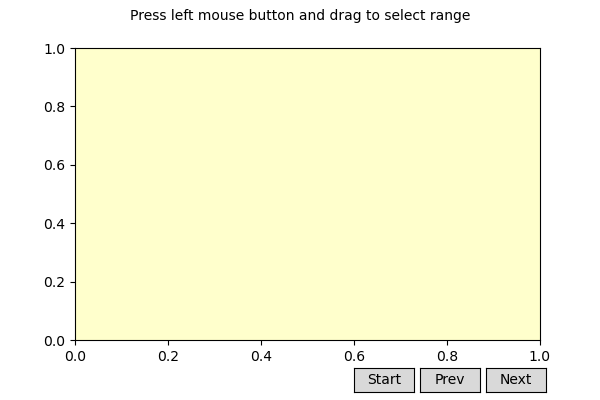

In [33]:
a=LinReg(data_NADH4)

In [34]:
slopes4 = a.make_summary()
slopes4.head()

,rate
Sample_A1,-0.020217
Sample_A2,-0.020348
Sample_A3,-0.015801
Sample_B1,-0.022346
Sample_B2,-0.026170


In [77]:
slopes4

,rate
Sample_A1,-0.023562
Sample_A2,-0.024022
Sample_A3,-0.022307
Sample_B1,-0.022182
Sample_B2,-0.026059
Sample_B3,-0.011606
Sample_C1,-0.018658
Sample_C2,-0.013473
Sample_C3,-0.015393
Sample_D1,-0.014311


In [84]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [85]:
slopes4 = slopes4 / El # umol/ml/min (mM/min)
slopes4 = slopes4 / (protein/V) # umol/min/mg prot
#frame_pre_complete = frame / (-1) #sign change if needed 
exp4rates = -slopes4

In [90]:
writer = pandas.ExcelWriter('output2virexp4.xlsx')
exp4rates.to_excel(writer, sheet_name='exp4')
writer.save()

# Experiment 5: 0.067mM NADH

In [2]:
data_NADH5 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD5.xlsx")
#A view of the data
data_NADH5.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.378311,0.369626,0.377545,0.423267,0.395810,0.454854,0.407687,0.343399,0.363307,...,0.296539,0.262490,0.268440,0.364719,0.379598,0.252802,0.265939,0.246456,0.266391,0.306439
1,0.074733,0.378083,0.372801,0.378293,0.410702,0.412621,0.472733,0.459577,0.341402,0.355500,...,0.296056,0.262918,0.269891,0.382817,0.389769,0.258742,0.259447,0.246057,0.262841,0.329970
2,0.158117,0.374387,0.370099,0.378406,0.398695,0.409962,0.468290,0.439230,0.347327,0.356446,...,0.292818,0.263090,0.271815,0.347518,0.375688,0.253586,0.259755,0.244213,0.259027,0.312047
3,0.241467,0.376439,0.370643,0.375327,0.408770,0.409181,0.461444,0.353518,0.349991,0.371345,...,0.293213,0.262921,0.271186,0.354401,0.379988,0.259248,0.259414,0.244210,0.260870,0.325459
4,0.324817,0.378992,0.371746,0.376654,0.397667,0.395356,0.445912,0.381282,0.358815,0.354834,...,0.293801,0.260903,0.276238,0.337016,0.370415,0.251770,0.260328,0.244049,0.260992,0.320551


In [3]:
data_NADH5.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH5.columns]
data_NADH5.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.378311,0.369626,0.377545,0.423267,0.395810,0.454854,0.407687,0.343399,0.363307,...,0.296539,0.262490,0.268440,0.364719,0.379598,0.252802,0.265939,0.246456,0.266391,0.306439
1,0.074733,0.378083,0.372801,0.378293,0.410702,0.412621,0.472733,0.459577,0.341402,0.355500,...,0.296056,0.262918,0.269891,0.382817,0.389769,0.258742,0.259447,0.246057,0.262841,0.329970
2,0.158117,0.374387,0.370099,0.378406,0.398695,0.409962,0.468290,0.439230,0.347327,0.356446,...,0.292818,0.263090,0.271815,0.347518,0.375688,0.253586,0.259755,0.244213,0.259027,0.312047
3,0.241467,0.376439,0.370643,0.375327,0.408770,0.409181,0.461444,0.353518,0.349991,0.371345,...,0.293213,0.262921,0.271186,0.354401,0.379988,0.259248,0.259414,0.244210,0.260870,0.325459
4,0.324817,0.378992,0.371746,0.376654,0.397667,0.395356,0.445912,0.381282,0.358815,0.354834,...,0.293801,0.260903,0.276238,0.337016,0.370415,0.251770,0.260328,0.244049,0.260992,0.320551


In [4]:
samples = [s for s in data_NADH5.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH5.index,
    index=(0,40),
    description='Time [min]',
)

In [5]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
        

C:\Users\Francel\AppData\Local\Temp\ipykernel_7040\2533943574.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_7040\2533943574.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


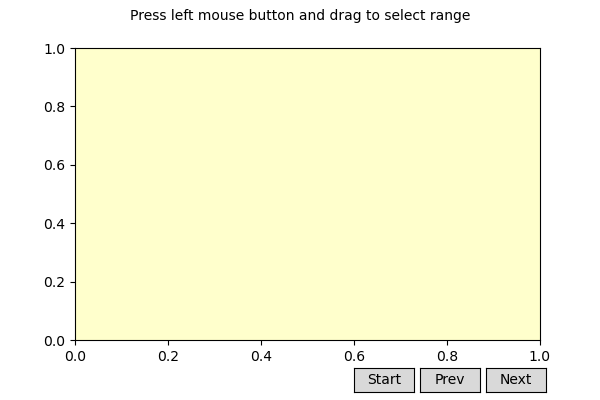

In [6]:
a=LinReg(data_NADH5)

In [7]:
slopes5 = a.make_summary()
slopes5.head()

,rate
Sample_A1,-0.012062
Sample_A2,-0.010144
Sample_A3,-0.006702
Sample_B1,-0.004911
Sample_B2,-0.005485


In [97]:
slopes5

,rate
Sample_A1,-0.016660
Sample_A2,-0.019641
Sample_A3,-0.023018
Sample_B1,-0.016762
Sample_B2,-0.012136
Sample_B3,-0.019951
Sample_C1,-0.026580
Sample_C2,-0.010090
Sample_C3,-0.006174
Sample_D1,-0.010808


In [104]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [105]:
slopes5 = slopes5 / El # umol/ml/min (mM/min)
slopes5 = slopes5 / (protein/V) # umol/min/mg prot
#slopes5_pre_complete = slopes5 / (-1) #sign change if needed 
exp5rates = -slopes5

In [109]:
writer = pandas.ExcelWriter('output3virexp5.xlsx')
exp5rates.to_excel(writer, sheet_name='exp5')
writer.save()

# Experiment 6: 0.05mM NADH

In [8]:
data_NADH6 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD6.xlsx")
#A view of the data
data_NADH6.head()

,Time_min,A4,A5,A6,B4,B5,B6,C4,C5,C6,...,D6,E4,E5,E6,F4,F5,F6,G4,G5,G6
0,0.000000,0.386375,0.389750,0.390137,0.373802,0.379614,0.470989,0.369934,0.349586,0.348313,...,0.288405,0.259012,0.247442,0.339211,0.271122,0.240929,0.252691,0.233836,0.239894,0.332154
1,0.077667,0.388158,0.388634,0.395137,0.378346,0.381611,0.437739,0.383483,0.342994,0.347887,...,0.288030,0.254737,0.251759,0.349595,0.284958,0.239745,0.251078,0.232538,0.240259,0.319967
2,0.161017,0.392352,0.392565,0.399636,0.379112,0.382320,0.418327,0.372961,0.354337,0.349248,...,0.293480,0.254623,0.253389,0.348164,0.301080,0.234305,0.253752,0.230963,0.236599,0.311176
3,0.244550,0.393392,0.390330,0.391678,0.372694,0.389141,0.427350,0.381772,0.352648,0.342197,...,0.285432,0.256147,0.251945,0.325872,0.279415,0.241170,0.251880,0.232692,0.241120,0.318886
4,0.327350,0.395036,0.397412,0.397506,0.371973,0.376512,0.431469,0.374942,0.332065,0.342247,...,0.285275,0.256560,0.247829,0.318504,0.250048,0.250722,0.264770,0.235292,0.239239,0.300205


In [9]:
data_NADH6.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH6.columns]
data_NADH6.head()

,Time_min,Sample_A4,Sample_A5,Sample_A6,Sample_B4,Sample_B5,Sample_B6,Sample_C4,Sample_C5,Sample_C6,...,Sample_D6,Sample_E4,Sample_E5,Sample_E6,Sample_F4,Sample_F5,Sample_F6,Sample_G4,Sample_G5,Sample_G6
0,0.000000,0.386375,0.389750,0.390137,0.373802,0.379614,0.470989,0.369934,0.349586,0.348313,...,0.288405,0.259012,0.247442,0.339211,0.271122,0.240929,0.252691,0.233836,0.239894,0.332154
1,0.077667,0.388158,0.388634,0.395137,0.378346,0.381611,0.437739,0.383483,0.342994,0.347887,...,0.288030,0.254737,0.251759,0.349595,0.284958,0.239745,0.251078,0.232538,0.240259,0.319967
2,0.161017,0.392352,0.392565,0.399636,0.379112,0.382320,0.418327,0.372961,0.354337,0.349248,...,0.293480,0.254623,0.253389,0.348164,0.301080,0.234305,0.253752,0.230963,0.236599,0.311176
3,0.244550,0.393392,0.390330,0.391678,0.372694,0.389141,0.427350,0.381772,0.352648,0.342197,...,0.285432,0.256147,0.251945,0.325872,0.279415,0.241170,0.251880,0.232692,0.241120,0.318886
4,0.327350,0.395036,0.397412,0.397506,0.371973,0.376512,0.431469,0.374942,0.332065,0.342247,...,0.285275,0.256560,0.247829,0.318504,0.250048,0.250722,0.264770,0.235292,0.239239,0.300205


In [10]:
samples = [s for s in data_NADH6.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH6.index,
    index=(0,40),
    description='Time [min]',
)

In [11]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
        

C:\Users\Francel\AppData\Local\Temp\ipykernel_7040\2533943574.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_7040\2533943574.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


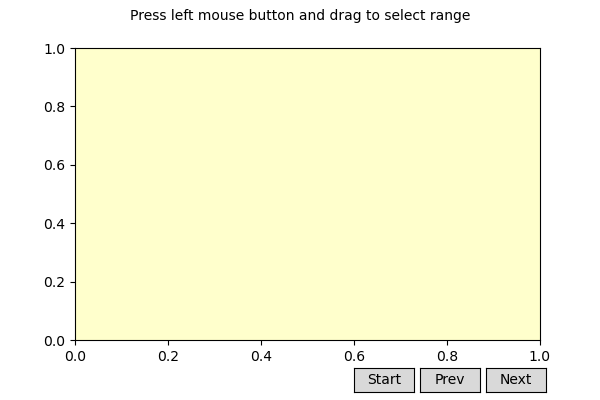

In [12]:
a=LinReg(data_NADH6)

In [115]:
slopes6 = a.make_summary()
slopes6.head()

,rate
Sample_A4,-0.009761
Sample_A5,-0.009901
Sample_A6,-0.011223
Sample_B4,-0.006595
Sample_B5,-0.007373


In [116]:
slopes6

,rate
Sample_A4,-0.009761
Sample_A5,-0.009901
Sample_A6,-0.011223
Sample_B4,-0.006595
Sample_B5,-0.007373
Sample_B6,-0.029954
Sample_C4,-0.023558
Sample_C5,-0.006041
Sample_C6,-0.008888
Sample_D4,-0.006760


In [123]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [124]:
slopes6 = slopes6 / El # umol/ml/min (mM/min)
slopes6 = slopes6 / (protein/V) # umol/min/mg prot
#slopes6_pre_complete = slopes6 / (-1) #sign change if needed 
exp6rates = -slopes6

In [128]:
writer = pandas.ExcelWriter('output4virexp6.xlsx')
exp6rates.to_excel(writer, sheet_name='exp6')
writer.save()

# Experiment 7: 0.042mM NADH

In [130]:
data_NADH7 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH = 8.0)\NAD7.xlsx")
#A view of the data
data_NADH7.head()

,Time_min,A7,A8,A9,B7,B8,B9,C7,C8,C9,...,D9,E7,E8,E9,F7,F8,F9,G7,G8,G9
0,0.000000,0.389968,0.391494,0.403651,0.391290,0.390775,0.325658,0.354886,0.349615,0.362348,...,0.293005,0.277364,0.273577,0.257484,0.269229,0.248345,0.254285,0.249412,0.243802,0.249370
1,0.075733,0.398973,0.392090,0.401827,0.407049,0.393868,0.345146,0.374387,0.345413,0.362584,...,0.295141,0.274052,0.275971,0.270804,0.283850,0.254865,0.255483,0.254224,0.251591,0.258696
2,0.159267,0.401086,0.386928,0.399492,0.406494,0.393613,0.364643,0.381391,0.345201,0.359767,...,0.298180,0.280463,0.271828,0.266324,0.289218,0.253707,0.256194,0.255231,0.260392,0.258952
3,0.242583,0.403905,0.388478,0.400102,0.401166,0.393340,0.353209,0.369202,0.344604,0.352755,...,0.293315,0.276859,0.271786,0.261849,0.263325,0.249212,0.261563,0.261430,0.255367,0.245127
4,0.326117,0.403042,0.394926,0.407331,0.398500,0.395696,0.351435,0.359288,0.343411,0.345781,...,0.292854,0.272178,0.267503,0.255766,0.267305,0.252925,0.261657,0.259555,0.252803,0.252385


In [131]:
data_NADH7.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH7.columns]
data_NADH7.head()

,Time_min,Sample_A7,Sample_A8,Sample_A9,Sample_B7,Sample_B8,Sample_B9,Sample_C7,Sample_C8,Sample_C9,...,Sample_D9,Sample_E7,Sample_E8,Sample_E9,Sample_F7,Sample_F8,Sample_F9,Sample_G7,Sample_G8,Sample_G9
0,0.000000,0.389968,0.391494,0.403651,0.391290,0.390775,0.325658,0.354886,0.349615,0.362348,...,0.293005,0.277364,0.273577,0.257484,0.269229,0.248345,0.254285,0.249412,0.243802,0.249370
1,0.075733,0.398973,0.392090,0.401827,0.407049,0.393868,0.345146,0.374387,0.345413,0.362584,...,0.295141,0.274052,0.275971,0.270804,0.283850,0.254865,0.255483,0.254224,0.251591,0.258696
2,0.159267,0.401086,0.386928,0.399492,0.406494,0.393613,0.364643,0.381391,0.345201,0.359767,...,0.298180,0.280463,0.271828,0.266324,0.289218,0.253707,0.256194,0.255231,0.260392,0.258952
3,0.242583,0.403905,0.388478,0.400102,0.401166,0.393340,0.353209,0.369202,0.344604,0.352755,...,0.293315,0.276859,0.271786,0.261849,0.263325,0.249212,0.261563,0.261430,0.255367,0.245127
4,0.326117,0.403042,0.394926,0.407331,0.398500,0.395696,0.351435,0.359288,0.343411,0.345781,...,0.292854,0.272178,0.267503,0.255766,0.267305,0.252925,0.261657,0.259555,0.252803,0.252385


In [132]:
samples = [s for s in data_NADH7.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH7.index,
    index=(0,40),
    description='Time [min]',
)

In [133]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_14528\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_14528\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


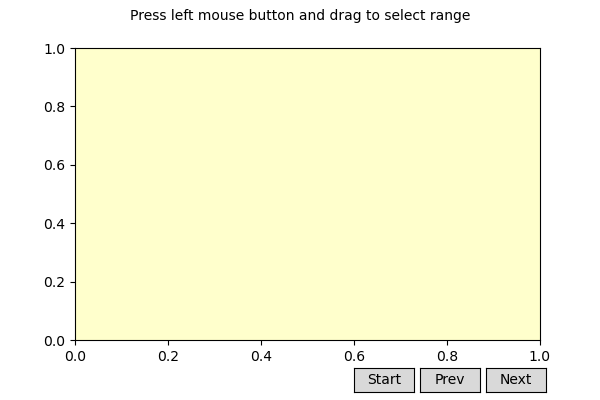

In [134]:
a=LinReg(data_NADH7)

In [135]:
slopes7 = a.make_summary()
slopes7.head()

,rate
Sample_A7,-0.008198
Sample_A8,-0.008399
Sample_A9,-0.007611
Sample_B7,-0.015862
Sample_B8,-0.010766


In [136]:
slopes7

,rate
Sample_A7,-0.008198
Sample_A8,-0.008399
Sample_A9,-0.007611
Sample_B7,-0.015862
Sample_B8,-0.010766
Sample_B9,-0.008357
Sample_C7,-0.016908
Sample_C8,-0.008883
Sample_C9,-0.001992
Sample_D7,-0.005753


In [143]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [144]:
slopes7 = slopes7 / El # umol/ml/min (mM/min)
slopes7 = slopes7 / (protein/V) # umol/min/mg prot
#slopes7_pre_complete = slopes7 / (-1) #sign change if needed 
exp7rates = -slopes7

In [147]:
writer = pandas.ExcelWriter('output6for exp7.xlsx')
exp7rates.to_excel(writer, sheet_name='exp7')
writer.save()